In [1]:
import os
import re
import matplotlib
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
plt.style.use('seaborn-darkgrid')

In [2]:
files = {os.path.splitext(k)[0]: {} for k in os.listdir('data') if '.csv' in os.path.splitext(k)[1]}

for i,file in enumerate(os.listdir('data')):
    ext = os.path.splitext(file)[1]
    name = os.path.splitext(file)[0]
    if '.csv' in ext:
        df = pd.read_csv(f'data/{file}')
        files[name] = df

In [10]:
def hz(frec):
    hz_ = 1/( (frec+1) * 120 * 8*10**-9 )
    return hz_

def vars_(df):
    X = np.array(df['X']) #* 1000
    Y = np.array(df['Y']) #* 1000
    R = np.sqrt(X**2 + Y**2)
    T = np.arctan(Y/X)
    return X,Y,R,T

def fc(frec):
    hz_ =  1/(2 * np.pi * (2 ** frec ) * 8 )*10**9
    return hz_

def transf(frec,C0,L,R,R2):
    w = frec * np.pi * 2
    A = C0**2*R2**2*w**2*(C0**2*L**2*w**4 + C0**2*R**2*w**2 - 4*C0*L*w**2 + 4)
    B = (C0**4*L**2*R2**2*w**6 + C0**4*R**2*R2**2*w**4 - 4*C0**3*L*R2**2*w**4 + C0**2*L**2*w**4 + C0**2*R**2*w**2 + 2*C0**2*R*R2*w**2 + 4*C0**2*R2**2*w**2 - 2*C0*L*w**2 + 1)
    func = A/B
    return func

def transf_original(frec,C,L,R,R2):
    w = frec * np.pi * 2
    t = R2/(np.sqrt( (R+R2)**2  + ( (w*L) - (1/(w*C)) )**2 ))
    return t


def chi_square(y_data, y_model, sigma):
    return np.sum((y_data/sigma - y_model/sigma)**2)

def r_chi_square(chi, y_data, dof):
    nu = len(list(y_data)) - 1 - dof
    if nu < 1:
        raise ValueError('length of y_data - 1 - dof should be greater than 1')
    return chi / nu

def p_value(chi, y_data, dof):
    nu = len(list(y_data)) - 1 - dof
    if nu < 1:
        raise ValueError('length of y_data - 1 - dof should be greater than 1')
    
    p = 1 - st.chi2.cdf(chi, nu)
    return p

def r_squared(y_data, y_model):
    ss_res = np.sum((y_data - y_model)**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    return 1 - (ss_res / ss_tot)

L=10 * 10**-3
C0= 100 *10**-9 
R = 12
R2 = 50

Covariance of coefficients:
[[ 1.85588800e-06 -2.47482151e-01 -1.25330701e+03 -1.19493282e+03]
 [-2.47482151e-01  3.30016763e+04  1.67128143e+08  1.59343961e+08]
 [-1.25330701e+03  1.67128143e+08  8.46375673e+11  8.06954772e+11]
 [-1.19493282e+03  1.59343961e+08  8.06954772e+11  7.69369943e+11]]
C0: 8.769183919817302e-08
L: 0.011700297914054384
R: 59.2528143249977
R2: 56.493139907517566
[[ 5.08661043e-03 -1.05596467e+02 -3.33304350e+05 -1.26086884e+05]
 [-1.05596467e+02  2.19215014e+06  6.91929569e+09  2.61752490e+09]
 [-3.33304350e+05  6.91929569e+09  2.18400428e+13  8.26194722e+12]
 [-1.26086884e+05  2.61752490e+09  8.26194722e+12  3.12544131e+12]]
C0: 2.372761271559139e-07
L: 0.004925779403772506
R: 15.54771419373542
R2: 5.88159995738632


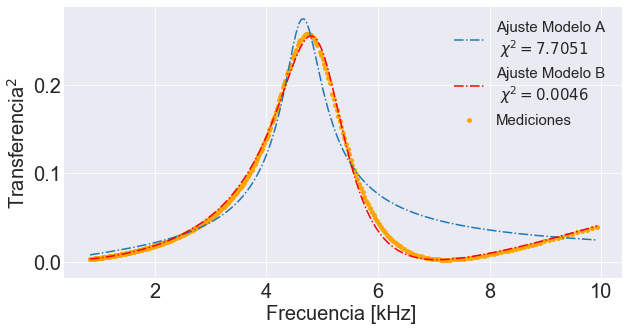

31219.21298704277


In [11]:
x,y,r,t = vars_(files['22']) 
r=2.02*r
frec = hz(files['22']['frecs'])
frec = frec[:431]
r = r[:431]
y = y[:431]

param_o, param_cov_o = curve_fit(transf_original,frec,r**2, p0=[C0,L,R,R2]) 
param, param_cov = curve_fit(transf,frec,r**2, p0=[C0,L,50,R2])

print("Covariance of coefficients:") 
print(param_cov) 
print(f'C0: {param[0]}')
print(f'L: {param[1]}')
print(f'R: {param[2]}')

print(f'R2: {param[3]}')

print(param_cov_o) 
print(f'C0: {param_o[0]}')
print(f'L: {param_o[1]}')
print(f'R: {param_o[2]}')
print(f'R2: {param_o[3]}')

%matplotlib inline
plt.figure(figsize=(10,5))
plt.scatter(frec/1000,r**2, s= 15, label ="Mediciones",color='orange')
plt.plot(frec/1000,transf_original(frec,param_o[0],param_o[1],param_o[2],param_o[3]), label =f"Ajuste Modelo A \n $\chi^2 = 7.7051$",ls='dashdot') 
plt.plot(frec/1000,transf(frec,param[0],param[1],param[2],param[3]), label ="Ajuste Modelo B\n $\chi^2 = 0.0046$",ls='dashdot',color='red') 
plt.ylabel(r'Transferencia$^{2}$',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
#plt.xlim([0,10])
#plt.ylim([0,0.32])
plt.legend(fontsize=15)
plt.show()
print(1/np.sqrt(param[0]*param[1]))


In [309]:
#bondad del fiteo NUESTRO
import scipy.stats as st
y_data = r**2
y_fit = transf(frec,param[0],param[1],param[2],param[3])

chi = chi_square(y_data, y_fit, 1)
r_ = r_chi_square(chi, y_data, len(list(param)))
p = p_value(chi, y_data, len(list(param)))
r_sq = r_squared(y_data, y_fit)

print(f'Chi square: {chi:.4f}')
print(f'r: {r_:.6f}')
print(f'p-value: {p:.6f}')
print(f'r-squared: {r_sq:.4f}')

Chi square: 0.0046
r: 0.000011
p-value: 1.000000
r-squared: 0.9977


In [12]:
#bondad del fiteo ORIGINAL
y_data = r**2
y_fit = transf_original(frec,param[0],param[1],param[2],param[3])

chi = chi_square(y_data, y_fit, 1)
r_ = r_chi_square(chi, y_data, len(list(param_o)))
p = p_value(chi, y_data, len(list(param_o)))
r_sq = r_squared(y_data, y_fit)

print(f'Chi square: {chi:.4f}')
print(f'r: {r_:.4f}')
print(f'p-value: {p:.6f}')
print(f'r-squared: {r_sq:.4f}')


NameError: name 'st' is not defined

In [316]:
r'$$\omega$$'

'$$\\omega$$'

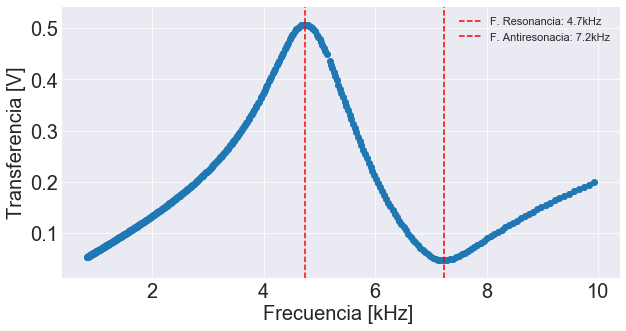

In [24]:
plt.figure(figsize=(10,5))
plt.scatter(frec/1000,r)
plt.ylabel(r'Transferencia [V]',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
#plt.xlim([0,10])
#plt.ylim([0,0.32])
plt.axvline(frec[318]/1000,ls='dashed',color='red',label=f'F. Resonancia: {np.round(frec[318]/1000,1)}kHz')
plt.axvline(frec[391]/1000,ls='dashed',color='red',label=f'F. Antiresonacia: {np.round(frec[391]/1000,1)}kHz')
plt.legend(fontsize=11)

In [20]:
np.where(r ==0.047176361630353755)

(array([391], dtype=int64),)

31071.709265190857


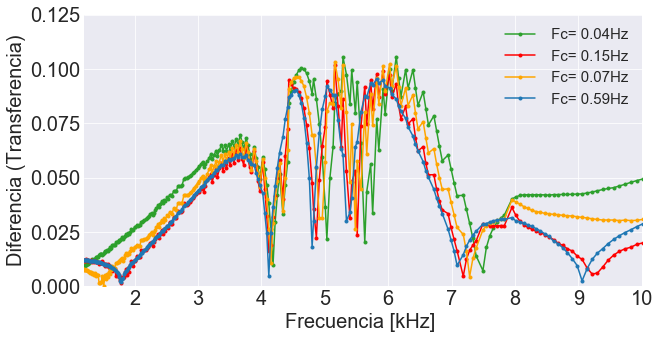

In [132]:
fs = ['29', '27', '28', '25']
c = ['C2','red','orange','C0']
mod_a = []
mod_b = []
plt.figure(figsize=(10,5))
for i,f in enumerate(fs):
    x,y,r,t = vars_(files[f]) 
    r=2.02*r
    frec = hz(files[f]['frecs'])


    param_o, param_cov_o = curve_fit(transf_original,frec,r**2, p0=[C0,L,R,R2]) 
    param, param_cov = curve_fit(transf,frec,r**2, p0=[C0,L,50,R2])

    data = r**2
    modelo_a = transf_original(frec,param_o[0],param_o[1],param_o[2],param_o[3])
    modelo_b = transf(frec,param[0],param[1],param[2],param[3])

    dist_a = np.abs(data-modelo_a)
    dist_b = np.abs(data-modelo_b)
    mod_a.append(dist_a)
    mod_b.append(dist_b)
    
    #plt.plot(frec/1000,dist_a, label =f"Ajuste Modelo A, Fc= {f}",color=c[i]) 
    plt.plot(frec/1000,np.sqrt(dist_b),'.-', label =f" Fc= {np.round(fc(int(f)),2)}Hz",color=c[i]) 
plt.ylabel(r'Diferencia (Transferencia)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.xlim([1.2,10])
plt.ylim([0,0.125])
print(1/np.sqrt(param[0]*param[1]))

(1.2, 10)

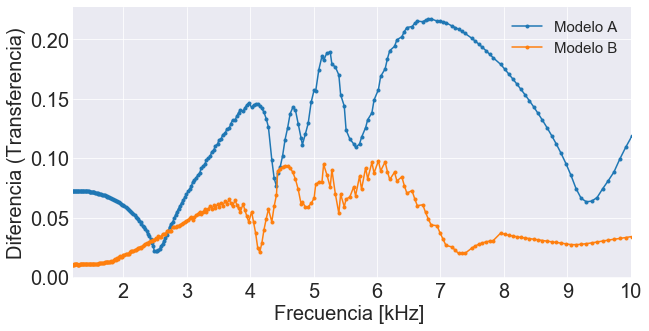

In [125]:
a = np.transpose(np.array(mod_a))
b = np.transpose(np.array(mod_b))
a_ = []
b_ = []

for i in range(len(a)):
    a_.append(np.mean(a[i]))
    b_.append(np.mean(b[i]))
plt.figure(figsize=(10,5))
plt.plot(frec/1000,np.sqrt(a_),'.-',label='Modelo A')
plt.plot(frec/1000,np.sqrt(b_),'.-',label='Modelo B')
plt.ylabel(r'Diferencia (Transferencia)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.xlim(1.2,10)

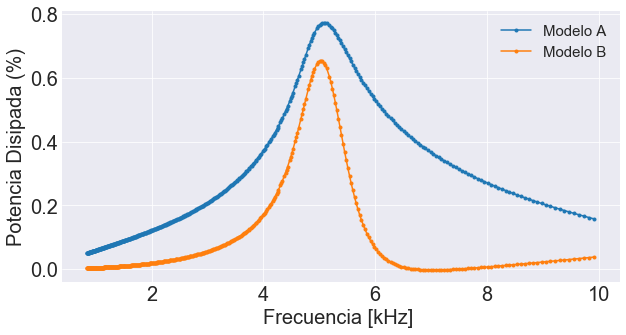

In [242]:
# porentaje de potencia disipada
%matplotlib inline
pot_a =  1 - np.abs((r**2 - transf_original(frec,C0,L,R,R2) + 1) /(transf_original(frec,C0,L,R,R2) + 1)) 
pot_b =1 - np.abs((r**2 - transf(frec,C0,L,R,R2) + 1) / (transf(frec,C0,L,R,R2) + 1) )
plt.figure(figsize=(10,5))
plt.plot(frec/1000,pot_a,'.-',label='Modelo A')
plt.plot(frec/1000,pot_b,'.-',label='Modelo B')
plt.ylabel(r'Potencia Disipada (%)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)

(1.2, 10)

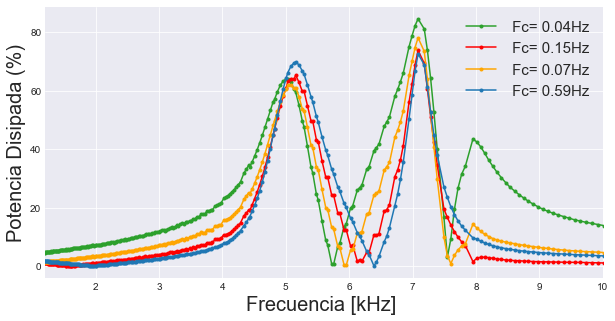

In [197]:
%matplotlib inline

plt.figure(figsize=(10,5))
for i,f in enumerate(fs):
    x,y,r,t = vars_(files[f]) 
    r=2.02*r
    frec = hz(files[f]['frecs'])

    pot_b = np.abs(r - np.sqrt(transf(frec,C0,L,R,R2))) / np.abs(r) *100
    
    #plt.plot(frec/1000,dist_a, label =f"Ajuste Modelo A, Fc= {f}",color=c[i]) 
    plt.plot(frec/1000,pot_b,'.-', label =f" Fc= {np.round(fc(int(f)),2)}Hz",color=c[i]) 
plt.ylabel(r'Potencia Disipada (%)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.legend(fontsize=15)
plt.xlim([1.2,10])

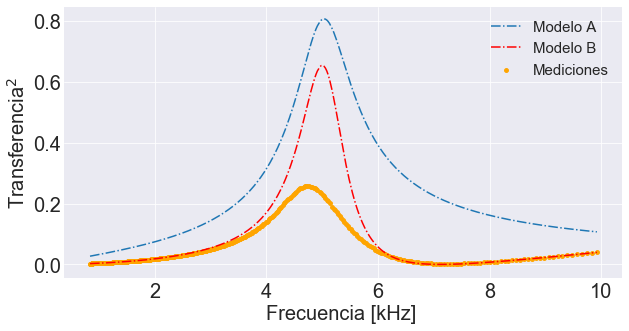

In [238]:
plt.figure(figsize=(10,5))
plt.scatter(frec/1000,r**2, s= 15, label ="Mediciones",color='orange')
plt.plot(frec/1000,transf_original(frec,C0,L,R,R2) , label ="Modelo A",ls='dashdot') 
plt.plot(frec/1000,transf(frec,C0,L,R,R2) , label ="Modelo B",ls='dashdot',color='red') 
plt.ylabel(r'Transferencia$^{2}$',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.show()

30931.159607281985


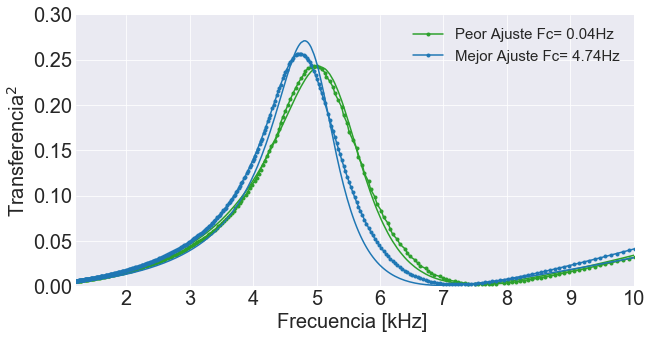

In [240]:
fs = ['29', '22']
c = ['C2','C0']
lab = ['Peor','Mejor']
plt.figure(figsize=(10,5))
for i,f in enumerate(fs):
    x,y,r,t = vars_(files[f]) 
    r=2.02*r
    frec = hz(files[f]['frecs'])


    param_o, param_cov_o = curve_fit(transf_original,frec,r**2, p0=[C0,L,R,R2]) 
    param, param_cov = curve_fit(transf,frec,r**2, p0=[C0,L,50,R2])

    data = r**2
    modelo_a = transf_original(frec,param_o[0],param_o[1],param_o[2],param_o[3])
    modelo_b = transf(frec,param[0],param[1],param[2],param[3])

    
    plt.plot(frec/1000,modelo_b,color=c[i]) 
    plt.plot(frec/1000,data,'.-',color=c[i],label =f"{lab[i]} Ajuste Fc= {np.round(fc(int(f)),2)}Hz") 
plt.ylabel(r'Transferencia$^2$',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.xlim([1.2,10])
plt.ylim([0,0.3])
print(1/np.sqrt(param[0]*param[1])) 